In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [6]:
save_images = False

In [7]:
from narrative import nar181026_heat_confidence_genes

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')  # only consider supported protein coding-genes

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
pfus=[0]

In [10]:
first = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'first') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]

In [11]:
second = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'second') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]

In [12]:

ages = [9, 12, 18, 24]

out = pd.DataFrame(index=tissues_to_consider, columns=ages)

In [13]:
from scipy.stats import spearmanr

In [14]:
agg = []

for tissue in tissues_to_consider:
    for age in ages:
        fi = first[
            (first['older']==age) & 
            (first['tissue']==tissue)            
        ][['gene_ncbi', 'o_over_y']]
        
        
        se = second[
            (second['older']==age) & 
            (second['tissue']==tissue)          
        ][['gene_ncbi', 'o_over_y']]
        
        m =pd.merge(fi, se, on='gene_ncbi', how='inner', suffixes=('_fi', '_se'))
        
        di = dict()
        di['tissue'] = tissue
        di['age'] = age
        di['rho'] = spearmanr(m['o_over_y_fi'], m['o_over_y_se'])[0]
        agg.append(di)

In [15]:
o = pd.DataFrame(agg)

In [16]:
h = o.pivot(index='tissue', columns='age', values='rho')

In [17]:
f = h>0

In [18]:
h[~f] = 0

In [19]:
def nice_plot(h):
    t = h.copy()
    
    tissue_dict = {
        'Adrenal': 'Adrenal gland',
        'BAT': 'Brown adipose tissue',
        'Blood': 'Blood',
        'Brain': 'Frontal cortex',
        'Cerebellum': 'Cerebellum',
        'Esophagus': 'Esophagus',
        'GutEP': 'Gut epithelium',
        'Heart': 'Heart',
        'Kidney': 'Kidney',
        'LI': 'Large intestine',
        'Liver': 'Liver',
        'Lung': 'Lung',
        'MuscSat': 'Muscle',
        'SI': 'Small intestine',
        'Skin': 'Skin',
        'Stomach': 'Stomach',
        'WAT': 'White adipose tissue'
    }
    
    t = t.rename(index=tissue_dict)
    t = t.sort_index()
    
    plt.figure(figsize=(4, 5))


    sns.heatmap(
        t, 
        cmap='YlOrBr', 
        annot=True,
        vmin=0,
        vmax=0.5
    )


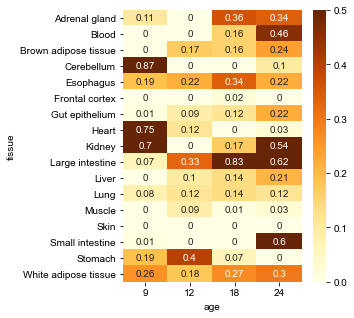

In [20]:
nice_plot(
    h.apply(lambda x: np.round(x, 2))
)


if save_images:
    export.export_image(
    '190406_correlation_in_fold_change_between_replicates/correlation_table_nice.pdf')

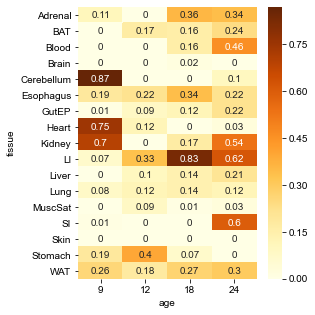

In [22]:
plt.figure(figsize=(4, 5))

sns.heatmap(
    h.apply(lambda x: np.round(x, 2)), 
    cmap='YlOrBr', 
    annot=True)


if save_images:
    export.export_image(
    '190406_correlation_in_fold_change_between_replicates/correlation_table.pdf')

In [23]:
o['diff']= (o['rho'] - np.quantile(o['rho'].fillna(0), 0.5)).apply(lambda x: abs(x))

In [24]:
o

,tissue,age,rho,diff
0,BAT,9,-0.255230,0.368909
1,BAT,12,0.171381,0.057702
2,BAT,18,0.163043,0.049364
3,BAT,24,0.237920,0.124242
4,Blood,9,0.001193,0.112485
...,...,...,...,...
63,Esophagus,24,0.223304,0.109626
64,Lung,9,0.082761,0.030918
65,Lung,12,0.124543,0.010864
66,Lung,18,0.143130,0.029452


In [28]:
def get_m(age, tissue):
    fi = first[
        (first['older']==age) & 
        (first['tissue']==tissue)            
    ][['gene_ncbi', 'o_over_y']]


    se = second[
        (second['older']==age) & 
        (second['tissue']==tissue)          
    ][['gene_ncbi', 'o_over_y']]

    m =pd.merge(fi, se, on='gene_ncbi', how='inner', suffixes=('_fi', '_se'))
    print('data points', len(m))
    return m

data points 11263


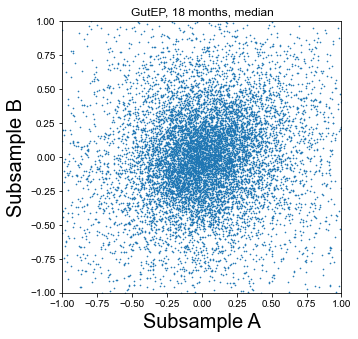

In [29]:
m = get_m(18, 'GutEP')


plt.figure(figsize=(5, 5))
plt.scatter(m['o_over_y_fi'], m['o_over_y_se'], s=0.4)
plt.xlim((-1, 1))
plt.ylim((-1, 1))

plt.xlabel('Subsample A', fontsize=20)
plt.ylabel('Subsample B', fontsize=20)

plt.title('GutEP, 18 months, median')


if save_images:
    export.export_image(
    '190406_correlation_in_fold_change_between_replicates/median.pdf')

data points 1465


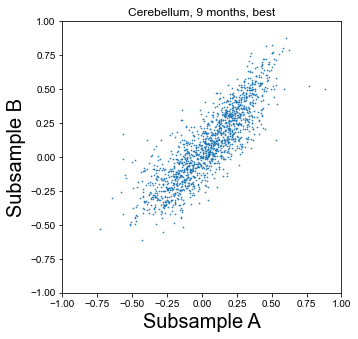

In [30]:
m = get_m(9, 'Cerebellum')

plt.figure(figsize=(5, 5))
plt.scatter(m['o_over_y_fi'], m['o_over_y_se'], s=0.4)
plt.xlim((-1, 1))
plt.ylim((-1, 1))

plt.xlabel('Subsample A', fontsize=20)
plt.ylabel('Subsample B', fontsize=20)

plt.title('Cerebellum, 9 months, best')


if save_images:
    export.export_image(
    '190406_correlation_in_fold_change_between_replicates/best.pdf')

data points 8622


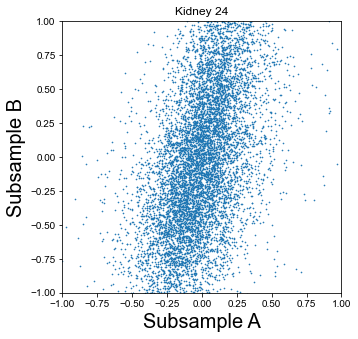

In [31]:
m = get_m(24, 'Kidney')


plt.figure(figsize=(5, 5))
plt.scatter(m['o_over_y_fi'], m['o_over_y_se'], s=0.4)
plt.xlim((-1, 1))
plt.ylim((-1, 1))

plt.xlabel('Subsample A', fontsize=20)
plt.ylabel('Subsample B', fontsize=20)

plt.title('Kidney 24')


if save_images:
    export.export_image(
    '190406_correlation_in_fold_change_between_replicates/kidney_24.pdf')

data points 14634


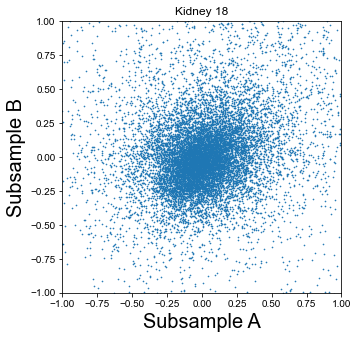

In [32]:
m = get_m(18, 'Kidney')


plt.figure(figsize=(5, 5))
plt.scatter(m['o_over_y_fi'], m['o_over_y_se'], s=0.4)
plt.xlim((-1, 1))
plt.ylim((-1, 1))

plt.xlabel('Subsample A', fontsize=20)
plt.ylabel('Subsample B', fontsize=20)

plt.title('Kidney 18')


if save_images:
    export.export_image(
    '190406_correlation_in_fold_change_between_replicates/kidney_18.pdf')

data points 8239


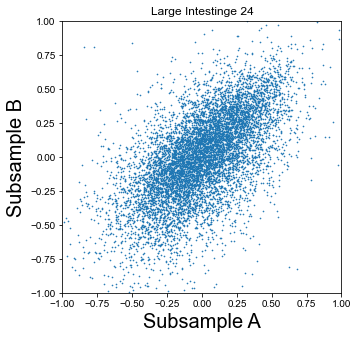

In [33]:
m = get_m(24, 'LI')


plt.figure(figsize=(5, 5))
plt.scatter(m['o_over_y_fi'], m['o_over_y_se'], s=0.4)
plt.xlim((-1, 1))
plt.ylim((-1, 1))

plt.xlabel('Subsample A', fontsize=20)
plt.ylabel('Subsample B', fontsize=20)

plt.title('Large Intestinge 24')


if save_images:
    export.export_image(
    '190406_correlation_in_fold_change_between_replicates/LI_24.pdf')